In [3]:
from calitp.tables import tbl
from siuba import *
from siuba.sql import sql_raw
from siuba.experimental import completer
from plotnine import *

## Are Feed Expiration dates meaningful and reliable?

In [4]:
tbl_expired_feeds = (tbl.gtfs_schedule.feed_info()                   
 >> mutate(feed_end_date_parsed = sql_raw('PARSE_DATE("%Y%m%d", feed_end_date)'))
 >> mutate( feed_date_ended = _.feed_end_date_parsed < "2021-07-01") 
 >> count(_.feed_date_ended, _.feed_end_date_parsed, _.calitp_itp_id)
 >> collect()
 >> mutate(feed_end_date_parsed = _.feed_end_date_parsed.astype("datetime64[ns]"))
)

In [5]:
tbl_expired_feeds >> filter(_.feed_end_date_parsed == _.feed_end_date_parsed.max()) 

,feed_date_ended,feed_end_date_parsed,calitp_itp_id,n
25,False,2029-12-31,281,1


* **What is the furthest future date in feed_info_end?** `2029-12-31`
* **How many feeds share this furthest feed_into_end date?** `One`

* **What is the oldest feed_start_date?** `2012-02-01`
* **How many feeds share this feed_start date?** `Two`

In [43]:
DATE_YEAR_AGO = "2020-07-14"
DATE_YEAR_OUT = "2022-07-12"
TODAY_DATE = "2020-07-15"

tbl_feed_info = (tbl.gtfs_schedule.feed_info()                   
     >> mutate(
         start_date = sql_raw('PARSE_DATE("%Y%m%d", feed_start_date)'),
         end_date = sql_raw('PARSE_DATE("%Y%m%d", feed_end_date)'),
         start_date_year_ago = _.start_date < DATE_YEAR_AGO,
         end_date_year_out = _.end_date > DATE_YEAR_OUT,
         date_diff_days=sql_raw("DATE_DIFF(end_date, start_date, DAY)"),
         date_diff_btn_year = _.date_diff_days < 365
     )
)


In [8]:
tbl_feed_counts = (
    tbl_feed_info 
    >> count(_.end_date) 
    >> collect() 
    >> arrange(-_.end_date)
    >> mutate(end_date = _.end_date.astype("datetime64[ns]"))
)

tbl_feed_counts >> head()

,end_date,n
35,2029-12-31,1
38,2024-06-14,1
12,2024-01-01,3
9,2022-12-31,3
44,2022-07-05,1


/Users/natalyadiaz/Cal-ITP/reports/env/lib/python3.9/site-packages/plotnine/layer.py:381: PlotnineWarning: position_stack : Removed 1 rows containing missing values.


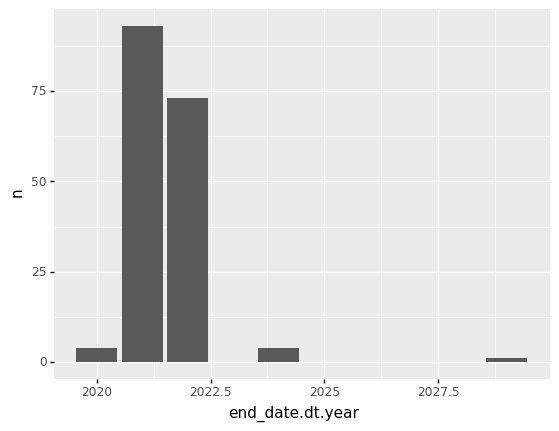

<ggplot: (312264322)>

In [9]:
#plot end date counts
tbl_feed_counts >> ggplot(aes("end_date.dt.year", "n")) + geom_col()

#need to change it to not .5 year

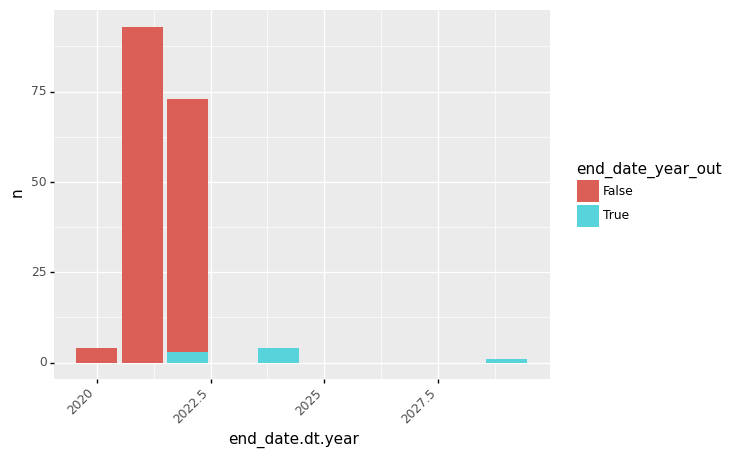

<ggplot: (312513127)>

In [21]:
# plot end date counts using tbl_feed_info 
(
    tbl_feed_info 
    >> collect()
    >> filter(_.end_date.notna())
    >> mutate(end_date = _.end_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("end_date.dt.year", "n", fill="end_date_year_out")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))
)
#missing years are not plotted

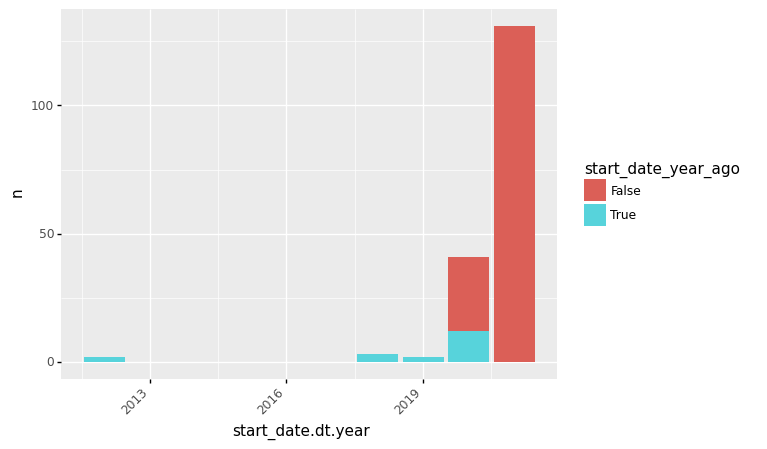

<ggplot: (312812782)>

In [29]:
# plot start date counts using tbl_feed_info 
(
    tbl_feed_info 
    >> collect()
    >> filter(_.start_date.notna())
    >> mutate(start_date = _.start_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("start_date.dt.year", "n", fill="start_date_year_ago")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))
)
#missing years are not plotted

In [13]:
# perform counts

tbl_feed_end_counts = (
    tbl_feed_info
    >> count(_.end_date)
    >> collect()
    >> arrange(-_.end_date)
    >> mutate(end_date=_.end_date.astype("datetime64[ns]"))
)
tbl_feed_start_counts = (
    tbl_feed_info
    >> count(_.start_date)
    >> collect()
    >> arrange(-_.start_date)
    >> mutate(end_date=_.start_date.astype("datetime64[ns]"))
)


In [44]:

tbl_expiration = (
    tbl_feed_info
    >> mutate(end_date_max=_.end_date.max(), start_date_min=_.start_date)
    >> summarize(
        end_date_max=_.end_date_max.max(),
        start_date_min=_.start_date_min.min(),
        n_end_date_max = (_.end_date == _.end_date_max).astype(int).sum(),
        #n_start_date_min=(_.end_date == _.end_date_max).astype(int).sum(),
        n_start_date_min=(_.start_date == _.start_date_min).astype(int).sum(),
        n_start_date_year=(_.start_date < DATE_YEAR_AGO).astype(int).sum(),
        n_end_date_year=(_.end_date > DATE_YEAR_OUT).astype(int).sum(),
        avg_date_diff=_.date_diff_days.mean().round(),
        n_date_diff_btn_year = _.date_diff_btn_year.astype(int).sum()
    
    )
)

In [97]:
tbl_agency_names = (tbl.views.gtfs_agency_names())

In [99]:
tbl_agency_names

,calitp_itp_id,calitp_url_number,agency_name
0,256,0,Porterville Transit
1,257,0,PresidiGo
2,259,0,Redding Area Bus Authority
3,4,0,AC Transit
4,260,0,Beach Cities Transit


In [98]:
tbl_expired_agencies = (
    tbl_expiration
    >> right_join(_, tbl_agency_names, ["calitp_itp_id"]
    >> collect())
)

TypeError: on must be a Mapping (e.g. dict)

In [96]:
#Which agency has that end date
tbl_feed_info >> filter(_.end_date == _.end_date.min())

,calitp_itp_id,calitp_url_number,feed_publisher_name,feed_publisher_url,feed_lang,default_lang,feed_start_date,feed_end_date,feed_version,feed_contact_email,feed_contact_url,calitp_extracted_at,start_date,end_date,start_date_year_ago,end_date_year_out,date_diff_days,date_diff_btn_year
0,344,0,"Trillium Solutions, Inc.",http://www.trilliumtransit.com,en,None,20181213,20200101,UTC: 13-Dec-2018 22:08,support+trinity-ca-us@trilliumtransit.com,http://support.trilliumtransit.com,2021-04-15,2018-12-13,2020-01-01,True,False,384,False
1,97,0,"Trillium Solutions, Inc.",http://www.trilliumtransit.com,en,None,20181210,20200101,UTC: 11-Dec-2018 00:26,support+duartetransit-ca-us@trilliumtransit.com,http://support.trilliumtransit.com,2021-04-15,2018-12-10,2020-01-01,True,False,387,False


In [40]:
#which agency has that start date 
tbl_feed_info >> filter(_.start_date == _.start_date.min())

,calitp_itp_id,calitp_url_number,feed_publisher_name,feed_publisher_url,feed_lang,default_lang,feed_start_date,feed_end_date,feed_version,feed_contact_email,feed_contact_url,calitp_extracted_at,start_date,end_date,start_date_year_ago,end_date_year_out,date_diff_days,date_diff_btw_year
0,256,0,National RTAP,http://www.nationalrtap.org,en,None,20120201,20201231,20170407,rtree@ci.porterville.ca.us,http://www.ridept.com,2021-04-15,2012-02-01,2020-12-31,True,False,3256,False
1,93,0,DART,http://www.tularecog.org/bustimes/,EN,None,20120201,20211215,20120202,None,None,2021-06-17,2012-02-01,2021-12-15,True,False,3605,False


In [45]:
tbl_expiration

,end_date_max,start_date_min,n_end_date_max,n_start_date_min,n_start_date_year,n_end_date_year,avg_date_diff,n_date_diff_btn_year
0,2029-12-31,2012-02-01,1,179,19,8,327.0,130


* **How Many feeds have a feed_info_end_date more than one year into the future?** `8`
* **How many feeds have a feed_start_date that is more than one year in the future?** `19`

* **What is the average length of time between a feed_info_start and feed_info_end?** `327 Days`
* **How many feeds have one year or less between feed_info_start and feed_info_end?** `130`


## How many agencies have invalid GTFS Data? 

In [136]:
#need to add calendar_expired feeds as well? 
tbl_calendar_expired_feeds = (tbl.gtfs_schedule.calendar())


In [137]:
tbl_calendar_info = (tbl.gtfs_schedule.calendar()                   
     >> mutate(
         calendar_start_date = sql_raw('PARSE_DATE("%Y%m%d", start_date)'),
         calendar_end_date = sql_raw('PARSE_DATE("%Y%m%d", end_date)'),
     )
)

In [138]:
tbl_calendar_expiration = (
    tbl_calendar_info
    >> mutate(calendar_end_date_max=_.calendar_end_date.max(), calendar_start_date_min=_.calendar_start_date.min())
    >> summarize (
    calendar_end_date_max =_.calendar_end_date_max.max(),
    calendar_start_date_min =_.calendar_start_date_min.min(),
    n_calendar_end_date_max = (_.calendar_end_date == _.calendar_end_date_max).astype(int).sum(),
    n_calendar_start_date_min=(_.calendar_start_date == _.calendar_start_date_min).astype(int).sum(),
    n_calendar_start_date_expired = (_.calendar_start_date > TODAY_DATE).astype(int).sum(),
    n_calendar_end_date_expired = (_.calendar_end_date < TODAY_DATE).astype(int).sum()    
                 )
)


In [139]:
tbl_calendar_info >> filter(_.calendar_end_date == _.calendar_end_date.min())

,calitp_itp_id,calitp_url_number,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,calitp_extracted_at,calendar_start_date,calendar_end_date
0,372,0,8f9ded8a-1484-43c6-af4a-9e2d6eebd86d,0,0,0,0,0,0,0,20160927,20170201,2021-04-15,2016-09-27,2017-02-01
1,372,0,3020bf5e-d46e-4ae5-ae93-d9371be32535,0,0,0,0,0,0,0,20160927,20170201,2021-04-15,2016-09-27,2017-02-01
2,372,0,b6f5b39c-40c8-407a-9942-1cb5080380f6,0,0,0,0,0,0,0,20160927,20170201,2021-04-15,2016-09-27,2017-02-01
3,372,0,109d55e2-3ef4-43bb-a939-6c8f38a6fae7,0,0,0,0,0,0,0,20160927,20170201,2021-04-15,2016-09-27,2017-02-01
4,372,0,8c9fbe7c-e76f-4025-bd91-7b202eddffd0,0,0,0,0,0,0,0,20160927,20170201,2021-04-15,2016-09-27,2017-02-01


In [140]:
tbl_calendar_expiration

,calendar_end_date_max,calendar_start_date_min,n_calendar_end_date_max,n_calendar_start_date_min,n_calendar_start_date_expired,n_calendar_end_date_expired
0,2100-01-01,2010-12-31,2,3,972,36


In [143]:
tbl_calendar_counts = (
tbl_calendar_info
>> count(_.calendar_end_date)
>> collect()
>> arrange(-_.calendar_end_date)
>> mutate(calendar_end_date = _.calendar_end_date.astype("datetime64[ns]"))
)
tbl_calendar_expired_feeds >> head()

,calitp_itp_id,calitp_url_number,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,calitp_extracted_at
0,4,0,1,0,0,0,0,0,0,1,20210613,20210807,2021-06-12
1,87,0,1,0,0,0,0,0,0,1,20210510,20210912,2021-05-10
2,61,0,1,1,0,0,0,0,0,0,20210606,20210807,2021-06-09
3,269,0,1,0,0,0,0,0,0,0,20210509,20210911,2021-05-06
4,361,0,1,0,0,0,0,0,1,0,20200912,20991231,2021-04-28


In [149]:
# perform counts

tbl_calendar_end_counts = (
    tbl_calendar_info
    >> count(_.calendar_end_date)
    >> collect()
    >> arrange(-_.calendar_end_date)
    >> mutate(calendar_end_date=_.calendar_end_date.astype("datetime64[ns]"))
)
tbl_calendar_start_counts = (
    tbl_calendar_info
    >> count(_.calendar_start_date)
    >> collect()
    >> arrange(-_.calendar_start_date)
    >> mutate(calendar_start_date=_.calendar_start_date.astype("datetime64[ns]"))
)

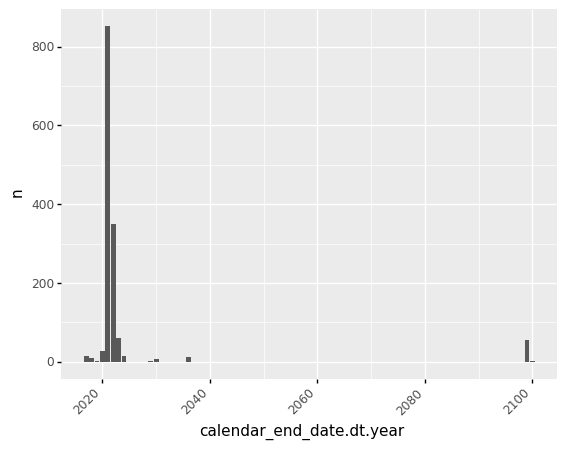

<ggplot: (315061875)>

In [108]:
#plot calendar end dates
tbl_calendar_counts >> ggplot(aes("calendar_end_date.dt.year", "n")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))                                                                             
                                                                                       

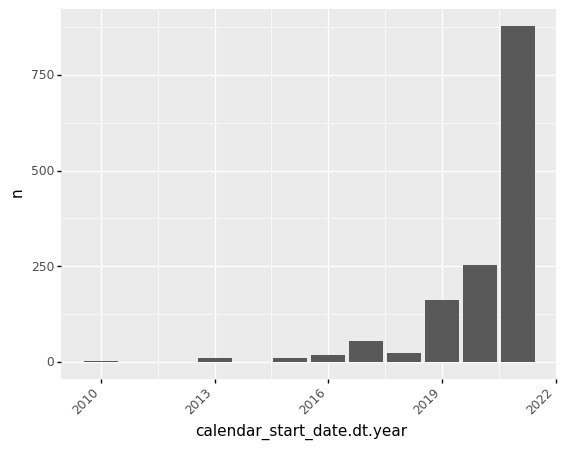

<ggplot: (332797501)>

In [147]:
#plot calendar start dates
tbl_calendar_start_counts>> ggplot(aes("calendar_start_date.dt.year", "n")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))

In [ ]:
#PLOT calendar end date expired
tbl_calendar_counts >> ggplot(aes("calendar_end_date.dt.year", "n")) + geom_col() + theme(axis_text_x = element_text(angle=45, hjust=1))


In [ ]:
#FIGURE OUT HOW TO ADD CALENDAR AND FEED END_DATES TOGETHER

In [95]:
tbl_expiration >> left_join(_, tbl_calendar_expired_feeds, on = "calitp_itp_id")

KeyError: 'calitp_itp_id'

## How "good" is California transit data?

In [50]:
tbl_validation_notices = (tbl.gtfs_schedule_type2.validation_notices())


In [51]:
tbl_validation_notices


,calitp_itp_id,calitp_url_number,calitp_extracted_at,calitp_deleted_at,code,severity,csvRowNumber,oldCsvRowNumber,newCsvRowNumber,csvRowNumberA,...,blockId,intersection,departureTime,arrivalTime,expectedLocationType,locationType,parentCsvRowNumber,parentLocationType,parentStation,parentStopName
0,380,0,2021-06-25,None,unknown_column,INFO,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,380,0,2021-06-25,None,unknown_column,INFO,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,183,0,2021-04-15,None,decreasing_or_equal_shape_distance,ERROR,32385.0,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,183,0,2021-04-15,None,leading_or_trailing_whitespaces,ERROR,2371.0,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,18,0,2021-04-15,2021-06-15,unknown_column,INFO,NaN,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [55]:
tbl_code_metrics = distinct(_.calitp_itp_id, _.calitp_url_number) >> count()

In [56]:
unique_codes = tbl_code_metrics >> distinct(_.code)

In [60]:
tbl_code_metrics

In [57]:
(
tbl.views.gtfs_agency_names()
>> left_join(_, unique_codes, sql_on = lambda lhs, rhs: True)
)

AttributeError: 'Pipeable' object has no attribute 'last_op'

In [53]:
(tbl.views.gtfs_agency_names()
>>left_join(_, tbl_code_metrics, ["calitp_id", "calitp_url_number"]))

NameError: name 'tbl_code_metrics' is not defined

## What errors should CAL-ITP target for resolution? 

* **In how many feeds does each error (including warning and info) appear?** 